# PyTorch qGAN + Europen Option Pricing

如果我们使用 $3$ 个量子比特来表示一个特征，我们有 $2^3 = 8$​ 个离散值。

In [27]:
import torch
from qiskit_machine_learning.utils import algorithm_globals
import numpy as np

num_dim = 1
num_discrete_values = 8
num_qubits = num_uncertainty_qubits = num_dim * int(np.log2(num_discrete_values))

使用对数正态分布生成了一维正态分布数据，并计算了相关的概率密度函数值。代码还设置了期权的参数，并计算了由对数正态分布得到的参数。

In [28]:

from scipy.stats import norm,lognorm

# 期权的参数(考虑的随机分布的参数)
S = 2.0  # 初始化股票价格
vol = 0.6  # 波动率
r = 0.05  # 无风险利率 
T = 60 / 365  # 到期时间

# 由对数正态分布得到的参数
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)
# 为了计算方便，我们将股票价格的最低值和最高值设置为均值的3倍标准差
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev


# 生成一维正态分布数据
coords = np.linspace(low, high, num_discrete_values)
rv = lognorm(loc=mu, scale=sigma,s=num_discrete_values)
grid_elements = np.transpose([np.tile(coords, 1)])
prob_data = rv.pdf(coords)
prob_data = prob_data / np.sum(prob_data)
print(grid_elements)


[[0.52282426]
 [0.9495905 ]
 [1.37635674]
 [1.80312298]
 [2.22988922]
 [2.65665546]
 [3.0834217 ]
 [3.51018794]]


让我们可视化我们的分布。它是一个在离散网格上满足对数正态分布点的概率分布。

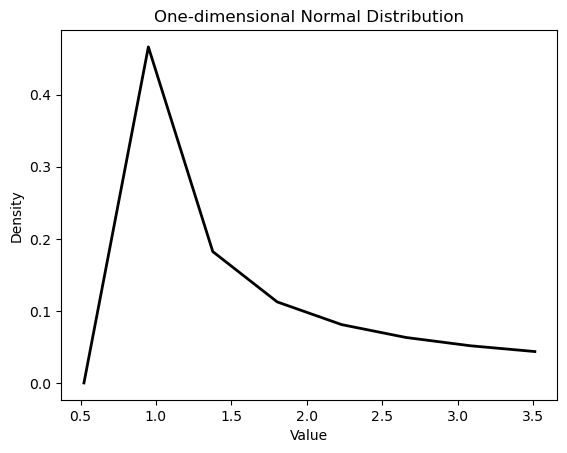

In [29]:
import matplotlib.pyplot as plt
from matplotlib import cm

# 绘制正态分布的概率密度函数
plt.plot(coords, prob_data, 'k', linewidth=2)
plt.title("One-dimensional Normal Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

## 神经网络的定义

### 量子神经网络 ansatz 的定义


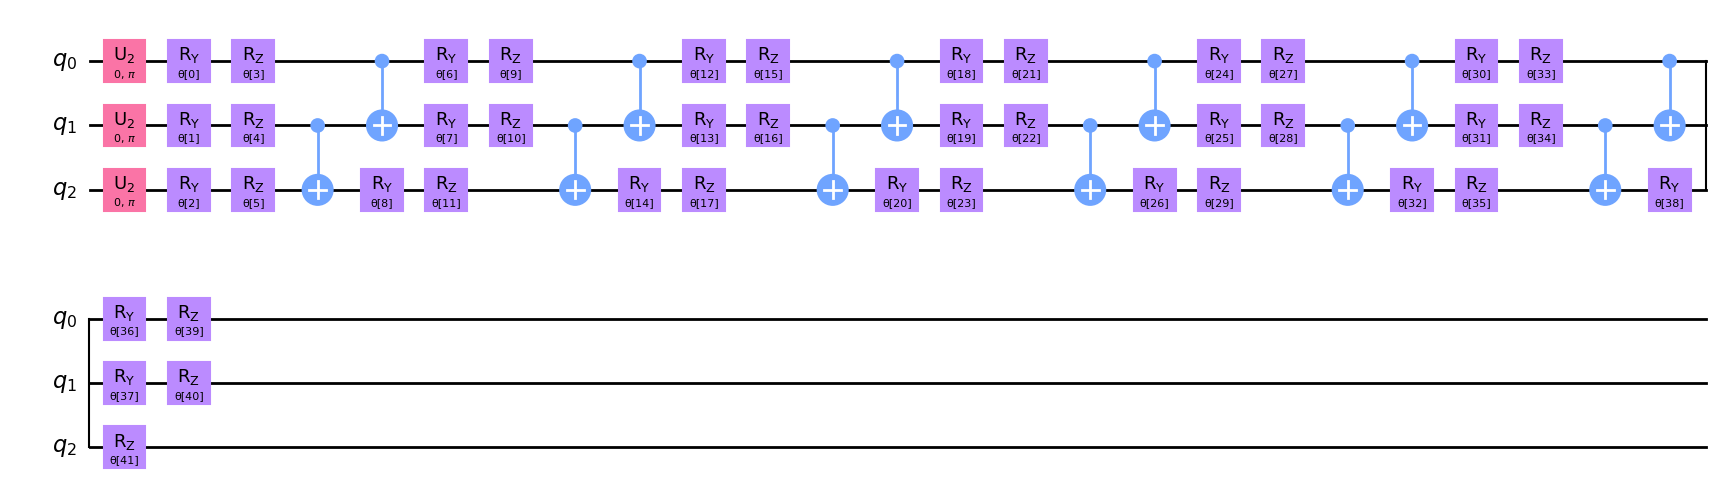

In [30]:

from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2

qc = QuantumCircuit(num_qubits)
qc.h(qc.qubits)

ansatz = EfficientSU2(num_qubits, reps=6)
qc.compose(ansatz, inplace=True)
qc.decompose().draw(output="mpl", style="clifford")

打印可训练参数的数量。

In [31]:
qc.num_parameters

42

### 量子生成器的定义

我们首先通过为 ansatz 创建一个采样器来定义生成器。参考实现是基于状态向量的实现，因此它返回电路执行结果的精确概率。在这种情况下，实现从测量的准概率分布中采样概率。

In [32]:
from qiskit.primitives import StatevectorSampler as Sampler

sampler = Sampler()


from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN


def create_generator() -> TorchConnector:
    qnn = SamplerQNN(
        circuit=qc,
        sampler=sampler,
        input_params=[],
        weight_params=qc.parameters,
        sparse=False,
    )

    initial_weights = algorithm_globals.random.random(qc.num_parameters)
    return TorchConnector(qnn, initial_weights)

#### 经典判别器的定义

接下来，我们定义一个基于 PyTorch 的经典神经网络，表示经典判别器。底层梯度可以通过 PyTorch 自动计算。

In [33]:
from torch import nn


class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 20)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear20 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear20(x)
        x = self.sigmoid(x)
        return x

### 创建生成器和判别器

现在我们创建一个生成器和一个判别器。

In [34]:
generator = create_generator()
discriminator = Discriminator(num_dim)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


## 设置训练循环

我们设置：

- 生成器和判别器的损失函数。
- 两者的优化器。
- 一个实用的绘图函数，用于可视化训练过程。
### 损失函数的定义

我们希望使用二元交叉熵作为损失函数来训练生成器和判别器：

$$
L(\boldsymbol{\theta}) = \sum_j p_j(\boldsymbol{\theta}) \left[y_j \log(x_j) + (1-y_j) \log(1-x_j)\right],
$$
其中 $x_j$ 指的是数据样本，$y_j$ 指的是相应的标签。

由于 PyTorch 的 `binary_cross_entropy` 对权重不可微分，我们手动实现损失函数，以便能够评估梯度。

In [35]:
def adversarial_loss(input, target, w):
    bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
    weighted_loss = w * bce_loss
    total_loss = -torch.sum(weighted_loss)
    return total_loss

### 4.2. 优化器的定义
为了训练生成器和判别器，我们需要定义优化方案。在接下来的步骤中，我们使用一种基于动量的优化器，称为 Adam，参考 [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980)。

In [36]:
from torch.optim import Adam

lr = 0.01  # 学习率
b1 = 0.7  # 第一个动量参数
b2 = 0.999  # 第二个动量参数

generator_optimizer = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)
discriminator_optimizer = Adam(
    discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005
)

训练过程的可视化

我们将通过绘制训练过程中生成器和判别器损失函数的演变，以及训练分布和目标分布之间相对熵的进展，来可视化训练过程。我们定义一个函数来绘制损失函数和相对熵。每当一个训练周期完成时，我们调用这个函数。

当收集到两个周期的训练数据时，训练过程的可视化开始。


In [37]:
from IPython.display import clear_output


def plot_training_progress():
    # we don't plot if we don't have enough data
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Generator Loss
    ax1.set_title("Loss")
    ax1.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax1.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax1.legend(loc="best")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.grid()

    # Relative Entropy
    ax2.set_title("Relative entropy")
    ax2.plot(entropy_values)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Relative entropy")
    ax2.grid()

    plt.show()

### 模型训练

在训练循环中，我们不仅监控损失函数，还监控相对熵。相对熵描述了分布的距离度量。因此，我们可以用它来评估训练分布与目标分布的接近程度。

现在，我们准备训练我们的模型。训练模型可能需要一些时间，请耐心等待。

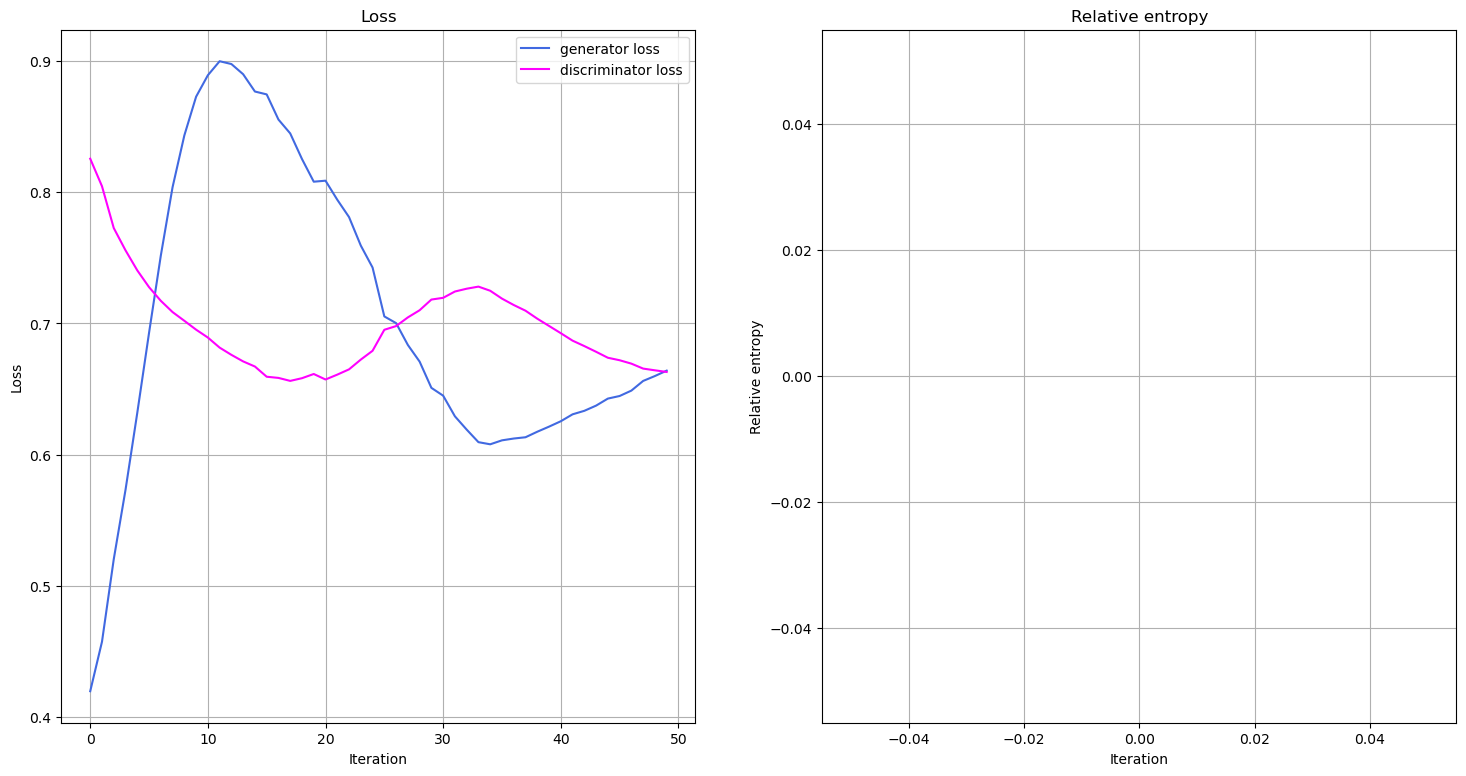

Fit in 74.20 sec


In [38]:
import time
from scipy.stats import multivariate_normal, entropy

n_epochs = 50

num_qnn_outputs = num_discrete_values**num_dim

generator_loss_values = []
discriminator_loss_values = []
entropy_values = []

start = time.time()
for epoch in range(n_epochs):

    valid = torch.ones(num_qnn_outputs, 1, dtype=torch.float)
    fake = torch.zeros(num_qnn_outputs, 1, dtype=torch.float)

    # 配置输入
    real_dist = torch.tensor(prob_data, dtype=torch.float).reshape(-1, 1)

    # 配置样本
    samples = torch.tensor(grid_elements, dtype=torch.float)
    disc_value = discriminator(samples)

    # 生成数据
    gen_dist = generator(torch.tensor([])).reshape(-1, 1)

    # 训练生成器
    generator_optimizer.zero_grad()
    generator_loss = adversarial_loss(disc_value, valid, gen_dist)

    # 存储以便绘图
    generator_loss_values.append(generator_loss.detach().item())

    generator_loss.backward(retain_graph=True)
    generator_optimizer.step()

    # 训练判别器
    discriminator_optimizer.zero_grad()

    real_loss = adversarial_loss(disc_value, valid, real_dist)
    fake_loss = adversarial_loss(disc_value, fake, gen_dist.detach())
    discriminator_loss = (real_loss + fake_loss) / 2

    # 存储以便绘图
    discriminator_loss_values.append(discriminator_loss.detach().item())

    discriminator_loss.backward()
    discriminator_optimizer.step()

    entropy_value = entropy(gen_dist.detach().squeeze().numpy(), prob_data)
    entropy_values.append(entropy_value)

    plot_training_progress()

elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} sec")

### 显示训练结果

我们将训练分布的结果生成

首先，我们在关闭 PyTorch 自动梯度的情况下生成一个新的概率分布，因为我们不再训练模型。

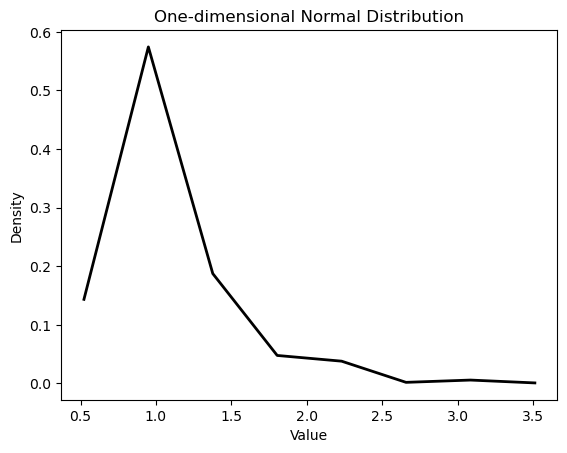

[0.14355469 0.57421875 0.1875     0.04785156 0.03808594 0.00195312
 0.00585938 0.00097656]


In [39]:
with torch.no_grad():
    generated_probabilities = generator().numpy()
    
# 绘制正态分布的概率密度函数
plt.plot(coords, generated_probabilities, 'k', linewidth=2)
plt.title("One-dimensional Normal Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()
print(generated_probabilities)

# 欧式看涨期权定价

## 导入必要库文件

In [40]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

from qiskit import QuantumCircuit
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit.primitives import Sampler as RefSampler
from qiskit_finance.circuit.library import LogNormalDistribution, UniformDistribution, NormalDistribution, GaussianConditionalIndependenceModel

## 构建不同概率分布下的不确定模型
1. 对数正态分布
2. 正态分布

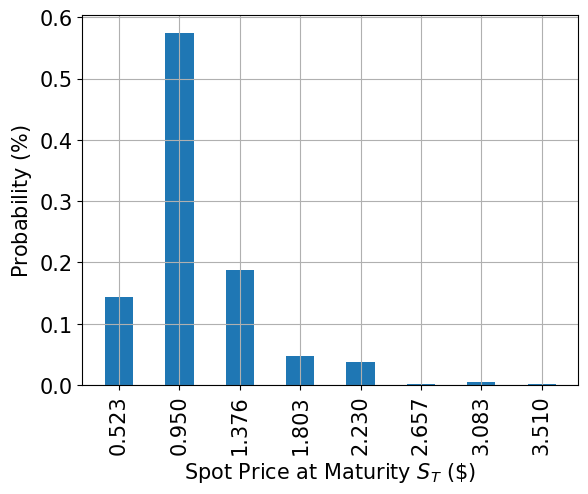

In [41]:
# 画出不确定模型的概率分布
x = coords
y = generated_probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel(r"Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel(r"Probability ($\%$)", size=15)
plt.show()


## 期望收益量子电路构建
> 参考论文：[Quantum risk analysis | npj Quantum Information (nature.com)](https://www.nature.com/articles/s41534-019-0130-6)
为了使用量子电路对三角式的易操作性，我们近似了期望收益的任务。

In [42]:
from qiskit.circuit.library import Initialize, Isometry
from typing import Tuple, List, Union, Optional

from qiskit.circuit import QuantumCircuit


class MyLogNormalDistribution(QuantumCircuit):

    def __init__(
        self,
        num_qubits: Union[int, List[int]],
        gene_prpo: List[float],
        bounds: Optional[Union[Tuple[float, float], List[Tuple[float, float]]]] = None,
        name: str = "P(X)",
    ) -> None:
        inner = QuantumCircuit(num_qubits, name=name)

        x = np.linspace(bounds[0], bounds[1], num=2**num_qubits)

        # compute the normalized, truncated probabilities
        normalized_probabilities = gene_prpo / np.sum(gene_prpo)
        # store as properties
        self._values = x
        self._probabilities = gene_prpo
        self._bounds = bounds

        super().__init__(*inner.qregs, name=name)

        init_params = np.sqrt(gene_prpo).astype(float)
        init_params = init_params / np.linalg.norm(init_params)
        initialize = Initialize(init_params) 
        circuit = initialize.gates_to_uncompute().inverse()
        inner.compose(circuit, inplace=True)
        self.append(inner.to_gate(), inner.qubits)

    @property
    def values(self) -> np.ndarray:
        """Return the discretized points of the random variable."""
        return self._values

    @property
    def probabilities(self) -> np.ndarray:
        """Return the sampling probabilities for the values."""
        return self._probabilities

    @property
    def bounds(self) -> Union[Tuple[float, float], List[Tuple[float, float]]]:
        """Return the bounds of the probability distribution."""
        return self._bounds

mylog = MyLogNormalDistribution(num_uncertainty_qubits, gene_prpo=generated_probabilities, bounds=(low, high))

# 设置期权的执行价格(应该在不确定模型的最低值和最高值之间)
strike_price = 1.896

# 设置目标函数的近似缩放
c_approx = 0.25


# 设置分段线性目标函数  
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

# 通过组合不确定模型和目标函数构建QAE的A算子
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(mylog, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

european_call.draw()

┌───────┐┌────┐
q_0: ┤0      ├┤0   ├
     │       ││    │
q_1: ┤1 P(X) ├┤1   ├
     │       ││    │
q_2: ┤2      ├┤2   ├
     └───────┘│    │
q_3: ─────────┤3 F ├
              │    │
q_4: ─────────┤4   ├
              │    │
q_5: ─────────┤5   ├
              │    │
q_6: ─────────┤6   ├
              └────┘

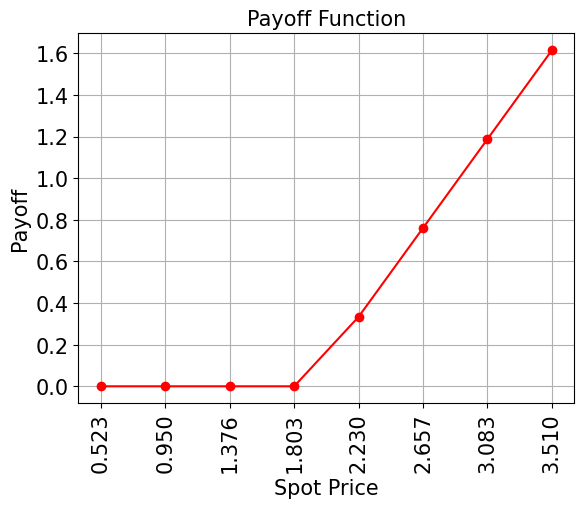

In [43]:
# 绘制期权的精确收益函数(但是这里会由于量子比特数量过少造成离散点的斜率不对齐的问题，执行价格附近最为明显)
x = mylog.values
y = np.maximum(0, x - strike_price)
plt.plot(x, y, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [44]:
# 计算精确的期望值(归一化到[0,1])和Delta值
exact_value = np.dot(mylog.probabilities, y)
exact_delta = sum(mylog.probabilities[x >= strike_price])
print("exact expected value:\t%.4f" % exact_value)
print("exact delta value:   \t%.4f" % exact_delta)

exact expected value:	0.0227
exact delta value:   	0.0469


### 执行预估期望收益的量子计算
> 这里使用`qiskit.primitives`内的Sampler进行量子计算

In [45]:
# 通过设置epsilon和alpha来控制估计的精度和置信度
epsilon = 0.01 # 1%的精度
alpha = 0.05 # 95%的置信度
# 我们要测量的量子比特的索引应该是量子比特数(因为python的索引是从0开始的)
# index_measured = num_uncertainty_qubits 

problem = EstimationProblem(
    state_preparation=european_call,
    objective_qubits=[num_uncertainty_qubits],
    post_processing=european_call_objective.post_processing,
)
# 构建振幅估计器
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=RefSampler(options={"shots": 100, "seed": 75})
)

result = ae.estimate(problem)


C:\Users\16579\AppData\Local\Temp\ipykernel_14712\2393410330.py:14: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  epsilon_target=epsilon, alpha=alpha, sampler=RefSampler(options={"shots": 100, "seed": 75})


In [46]:
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (result.estimation_processed))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.0227
Estimated value:    	0.0455
Confidence interval:	[0.0295, 0.0615]


## 测量Delta的电路构建

实现思路与期望收益的计算类似，只是不需要对算子近似，直接对辅助比特振幅测量即可。

In [47]:
from qiskit_finance.applications.estimation import EuropeanCallDelta

european_call_delta = EuropeanCallDelta(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    bounds=(low, high),
    uncertainty_model=mylog,
)
european_call_delta._objective.decompose().draw()

┌──────┐
state_0: ┤0     ├
         │      │
state_1: ┤1     ├
         │      │
state_2: ┤2     ├
         │  cmp │
state_3: ┤3     ├
         │      │
 work_0: ┤4     ├
         │      │
 work_1: ┤5     ├
         └──────┘

In [48]:
european_call_delta_circ = QuantumCircuit(european_call_delta._objective.num_qubits)
european_call_delta_circ.append(mylog, range(num_uncertainty_qubits))
european_call_delta_circ.append(
    european_call_delta._objective, range(european_call_delta._objective.num_qubits)
)

european_call_delta_circ.draw()

┌───────┐┌──────┐
q_0: ┤0      ├┤0     ├
     │       ││      │
q_1: ┤1 P(X) ├┤1     ├
     │       ││      │
q_2: ┤2      ├┤2     ├
     └───────┘│  ECD │
q_3: ─────────┤3     ├
              │      │
q_4: ─────────┤4     ├
              │      │
q_5: ─────────┤5     ├
              └──────┘

### 执行预估Delta的量子计算
> 这里使用`qiskit.primitives`内的Sampler进行量子计算

In [49]:
# 设置目标精度和置信度
epsilon = 0.01
alpha = 0.05

problem = european_call_delta.to_estimation_problem()

# 构建振幅估计器
ae_delta = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=RefSampler(options={"shots": 100, "seed": 75})
)

result_delta = ae_delta.estimate(problem)

C:\Users\16579\AppData\Local\Temp\ipykernel_14712\2162794056.py:9: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  epsilon_target=epsilon, alpha=alpha, sampler=RefSampler(options={"shots": 100, "seed": 75})


In [50]:
conf_int = np.array(result_delta.confidence_interval_processed)
print("Exact delta:    \t%.4f" % exact_delta)
print("Estimated value: \t%.4f" % european_call_delta.interpret(result_delta))
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact delta:    	0.0469
Estimated value: 	0.0472
Confidence interval: 	[0.0461, 0.0482]
